# KERAS 회귀 예제 : 실제 데이터로 만들어 보는 모델

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [90]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 데이터 파악하기

In [91]:
df = pd.read_csv("house_train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 결측치, 카테고리 변수 처리하기

In [92]:
# 결측치 확인
df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Condition2         0
dtype: int64

In [93]:
pre_df = pd.get_dummies(df)
pre_df = pre_df.fillna(pre_df.mean())
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## 속성별 관련도 추출하기

In [94]:
corr_df = pre_df.corr()
corr_sort_df = corr_df.sort_values(by='SalePrice', ascending=False)
corr_sort_df['SalePrice'].head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
BsmtQual_Ex     0.553105
TotRmsAbvGrd    0.533723
Name: SalePrice, dtype: float64

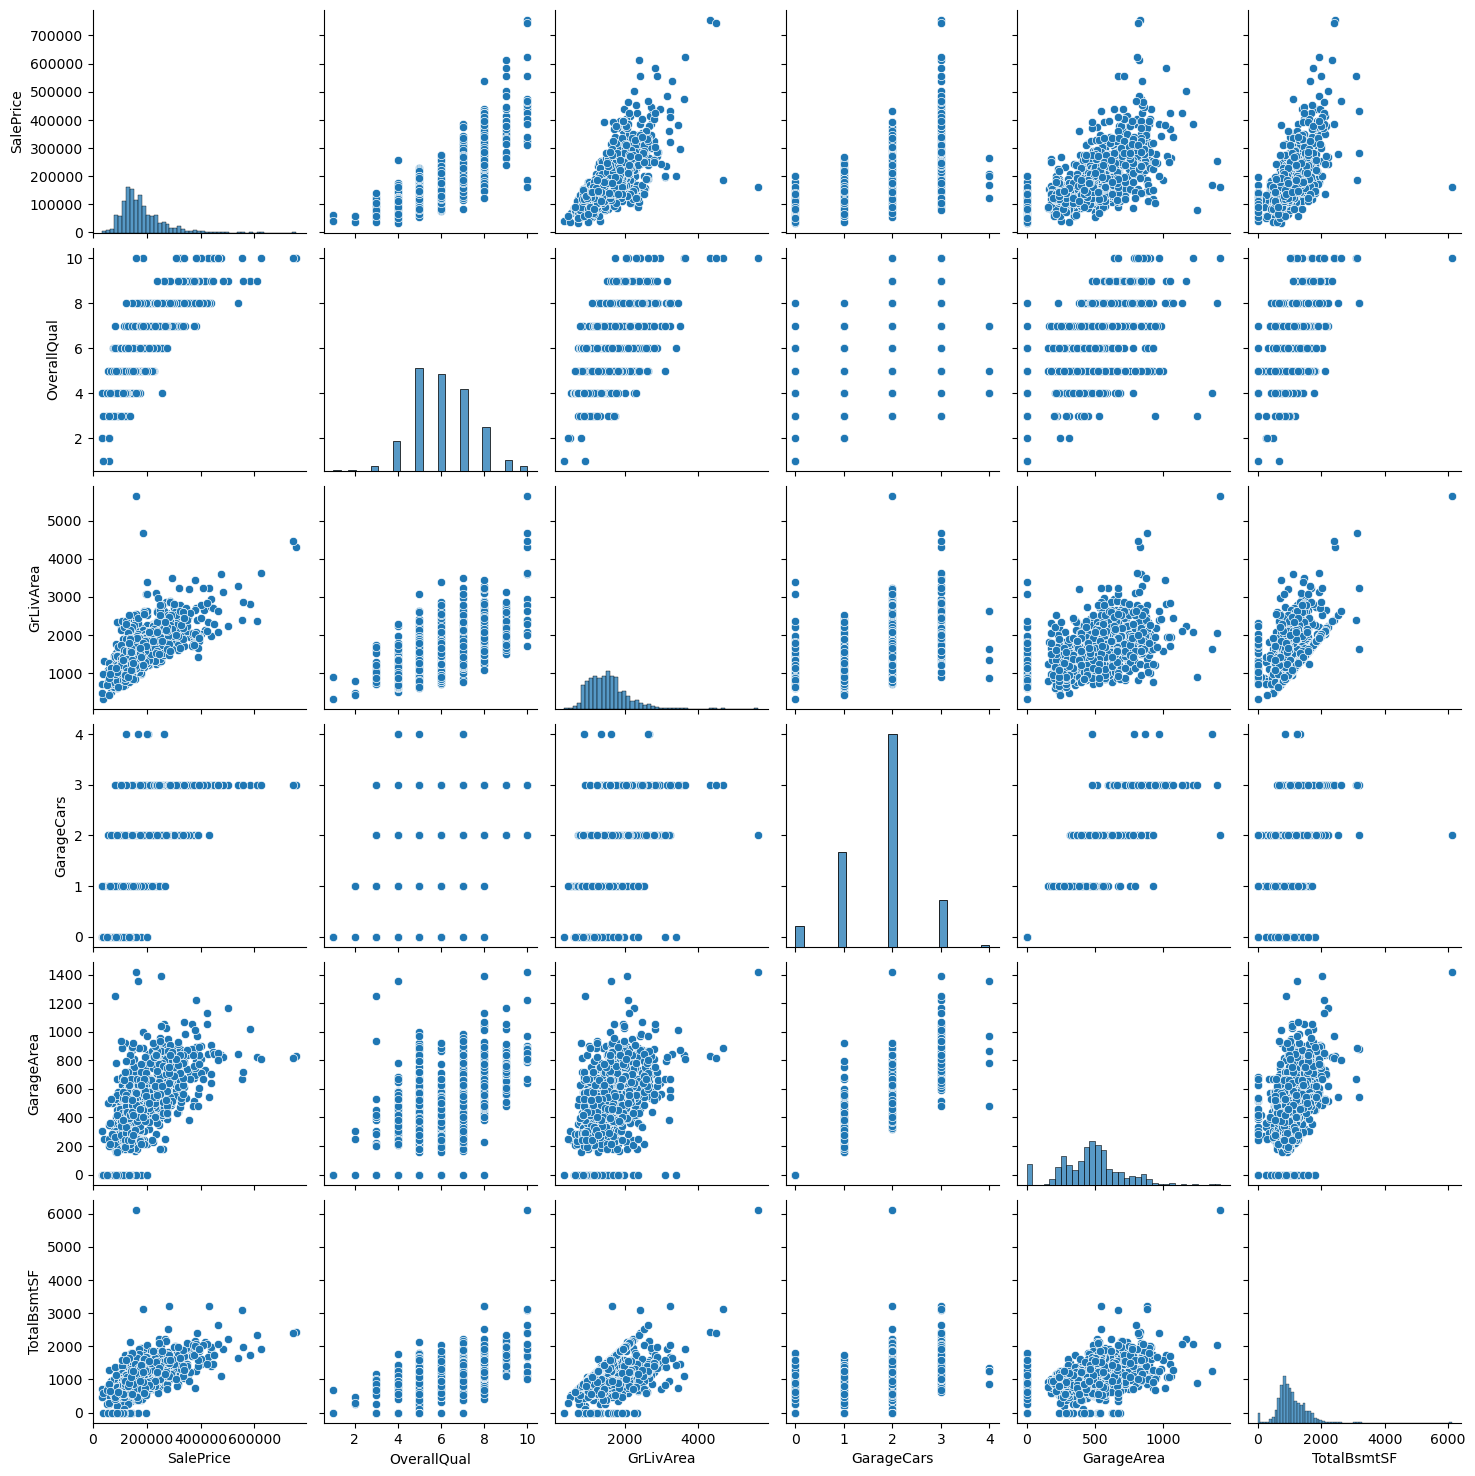

In [95]:
# 집 값과 관련도가 가장 높은 속성들을 추출해서 상관도 그래프를 그려봅니다.
cols=['SalePrice','OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF']
sns.pairplot(df[cols])
plt.show()

## 주택 가격 예측 모델

In [96]:
cols_train=['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF']
x_train_pre = pre_df[cols_train]
y = pre_df['SalePrice'].values
x_train, x_test, y_train, y_test = train_test_split(x_train_pre, y, test_size=0.2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1168, 5) (292, 5) (1168,) (292,)


In [97]:
model = Sequential()
model.add(Dense(10, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1)) # 회귀에서는 activation이 필요하지 않음
model.summary()

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # 분류
model.compile(loss='mean_squared_error', optimizer='adam') # 회귀

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)
checkpoint = ModelCheckpoint(filepath="house_train_best_model.keras", monitor='val_loss', verbose=0, save_best_only=True)
history = model.fit(x_train, y_train, epochs=2000, batch_size=32, validation_split=0.25, verbose=1, callbacks=[early_stopping_callback, checkpoint])

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 10)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 30)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 40)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,671 (6.53 KB)

 Trainable params: 1,671 (6.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 37914193920.0000 - val_loss: 41746530304.0000
Epoch 2/2000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37279576064.0000 - val_loss: 40695705600.0000
Epoch 3/2000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35791224832.0000 - val_loss: 38203379712.0000
Epoch 4/2000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32387125248.0000 - val_loss: 32512843776.0000
Epoch 5/2000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25021116416.0000 - val_loss: 21748011008.0000
Epoch 6/2000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13697862656.0000 - val_loss: 8889842688.0000
Epoch 7/2000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4591097856.0000 - val_loss: 2982519552.0000
Epoch 8/2000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2446996736.0000 - val_loss: 2727119872.0000
Epoch 9/2000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2428104192.0000 - val_loss: 2772546816.0000
Epoch 10/2000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

In [98]:
y_pred = model.predict(x_test)
print(y_pred.shape)
print(y_pred.flatten().shape)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
(292, 1)
(292,)


In [99]:
# 예측 값과 실제 값, 실행 번호가 들어갈 빈 리스트 생성
real_prices =[]
pred_prices = []
X_num = []

# 25개의 샘플을 뽑아 출력
n_iter = 0
Y_prediction = y_pred.flatten()
for i in range(25):
    real = y_test[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.2f}, 예상가격: {:.2f}".format(real, prediction))
    real_prices.append(real)
    pred_prices.append(prediction)
    n_iter = n_iter + 1
    X_num.append(n_iter)

실제가격: 136500.00, 예상가격: 121167.37
실제가격: 177000.00, 예상가격: 169308.30
실제가격: 295000.00, 예상가격: 361324.06
실제가격: 230000.00, 예상가격: 235582.02
실제가격: 116000.00, 예상가격: 133223.05
실제가격: 369900.00, 예상가격: 285911.78
실제가격: 118500.00, 예상가격: 142108.80
실제가격: 229456.00, 예상가격: 187609.19
실제가격: 115000.00, 예상가격: 139707.88
실제가격: 311872.00, 예상가격: 252334.41
실제가격: 153500.00, 예상가격: 156947.11
실제가격: 252000.00, 예상가격: 264430.38
실제가격: 394432.00, 예상가격: 270481.25
실제가격: 198900.00, 예상가격: 196356.33
실제가격: 143000.00, 예상가격: 193403.42
실제가격: 161500.00, 예상가격: 183275.73
실제가격: 268000.00, 예상가격: 244646.64
실제가격: 136500.00, 예상가격: 127534.79
실제가격: 120500.00, 예상가격: 125156.28
실제가격: 125000.00, 예상가격: 143403.89
실제가격: 227000.00, 예상가격: 214106.38
실제가격: 125000.00, 예상가격: 158535.12
실제가격: 100000.00, 예상가격: 111649.62
실제가격: 232000.00, 예상가격: 245356.44
실제가격: 193500.00, 예상가격: 219205.98


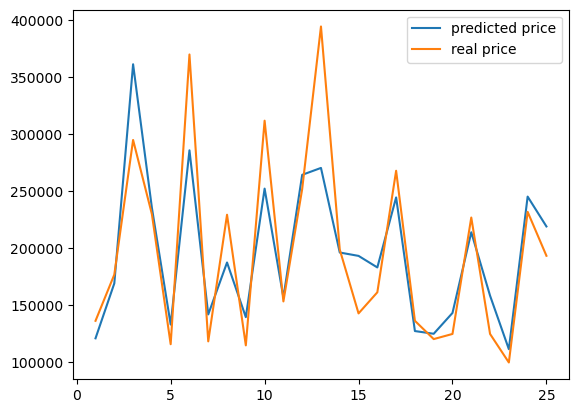

In [100]:
plt.plot(X_num, pred_prices, label='predicted price')
plt.plot(X_num, real_prices, label='real price')
plt.legend()
plt.show()